## Overview

Using [Gemma2_9b](https://huggingface.co/unsloth/gemma-2-9b-it-bnb-4bit) from unsloth team as base + LoRA adapter on top of it

using finetuned Gemma2 for multilingual tasks : https://huggingface.co/BAAI/bge-multilingual-gemma2  
-> A LLM-based multilingual embedding model, trained on a diverse range of languages and tasks. 

LoRA approximates model's weigths by factorising Q, K, V matrices into much smaller ones.  

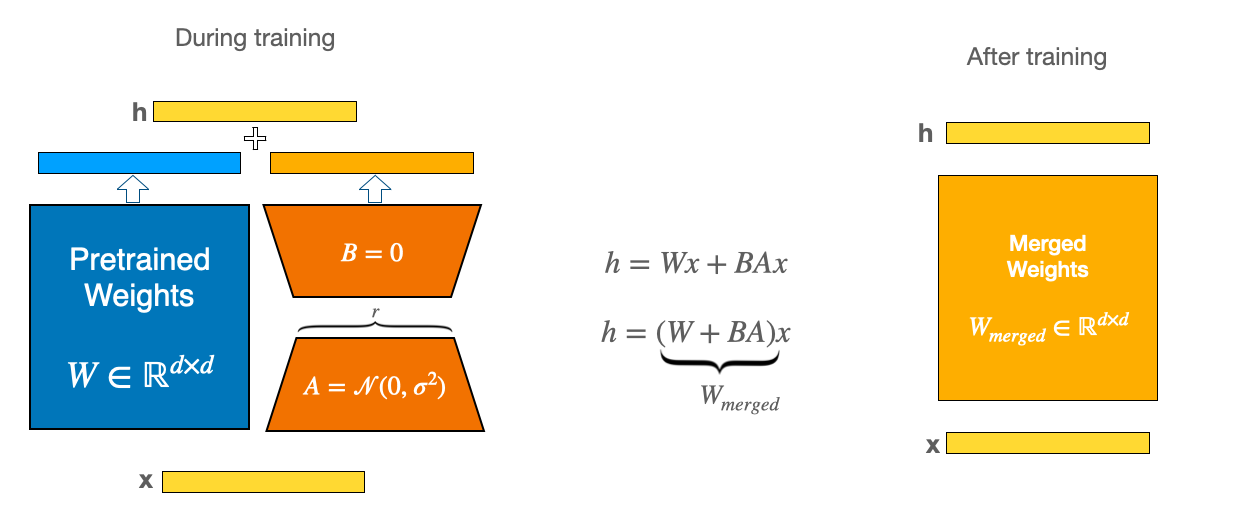  

Only those matrices will be updated during trainning -> reduce GPU memory usage. This is done with very little loss (casualities) on final metric.

> Note that QLoRA only quantize LLM's weights in low precision (e.g. 8-bit) while the computation of forward/backward are done in higher precision (e.g. 16-bit) and LoRA adapter's weights are also kept in higher precision.

HugginFace's Quantization Page : https://huggingface.co/docs/peft/developer_guides/quantization

Inspiration notebook https://www.kaggle.com/code/emiz6413/inference-gemma-2-9b-4-bit-qlora

Note : This will probably take a long time, i need to take some of mine to check for external compute resource for full trainning:
- RunPod : https://docs.runpod.io/tutorials/pods/run-fooocus
- Paperspace : https://www.paperspace.com/notebooks

## Imports

In [1]:
# gemma-2 is available from transformers>=4.42.3

import transformers as trsf
print("Transformers:", trsf.__version__)

#!pip install -U "transformers>=4.42.3" bitsandbytes accelerate peft

Transformers: 4.46.3


In [6]:
import os
import copy
from dataclasses import dataclass
import pickle

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import Tensor

#from datasets import Dataset

from tqdm import tqdm

from transformers import (
    BitsAndBytesConfig,
    Gemma2ForSequenceClassification,
    Gemma2Model,
    GemmaTokenizerFast,
    Gemma2Config,
    AutoTokenizer,
    AutoModel,
    PreTrainedTokenizerBase, 
    EvalPrediction,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

import ModelsUtils as Utils
import Configurations as Configs
#import wsdm_modelutils as Utils

SyntaxError: invalid syntax (391820795.py, line 40)

In [ ]:
import peft as pft
print("Peft:", pft.__version__)

Peft: 0.14.0


In [ ]:
print('Torch version:', torch.__version__)
print('Torch is build with CUDA:', torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Torch device : {device}')
print('------------------------------')

Torch version: 2.5.1+cu118
Torch is build with CUDA: True
Torch device : cuda
------------------------------


## Config

In [ ]:
config_file = 'Configs.py'
manager = Configs.ConfigManager(config_file)

config = manager.micro
config_save_load_gemma2_2b_fp16 = manager.save_load_gemma2_2b_fp16
config.config_name

'micro_gemma2_2b_fp16'

### Paths

In [ ]:
# for AutoModel and auto tokenizer
#base_model_path = '/kaggle/input/bge-multilingual-gemma2-fp16/pytorch/default/1/bge-multilingual-gemma2-fp16'
#base_model_path = '/kaggle/input/bge-multilingual-gemma2-fp16/pytorch/default/1/bge-multilingual-gemma2-fp16-4bit'
base_model_path = config.basemodel_path


# peft pre saved locally
#peft_model_path = '/kaggle/input/peftchkpt_original/pytorch/default/1/'
peft_model_path = '../Checkpoints/'
checkpoint_name = "Original_notrain"

#df = pd.read_csv('/kaggle/input/wsdm-preprocessed-full-original/train_preprocessed_FULL_original.csv')
#dataframe_path = '/kaggle/input/train-preprocessed-mini-original/train_preprocessed_MINI_original.csv'
dataframe_path = config.train_data


## Trainning Args

In [ ]:
#training_args = TrainingArguments(
#    output_dir="output",
#    overwrite_output_dir=True,
#    report_to="none",
#    num_train_epochs=config.n_epochs,
#    per_device_train_batch_size=config.train_batch,
#    gradient_accumulation_steps=config.gradient_accumulation_steps,
#    per_device_eval_batch_size=config.eval_batch,
#    logging_steps=10,
#    eval_strategy="epoch",
#    save_strategy="steps",
#    save_steps=200,
#    optim=config.optim_type,
#    fp16=True,
#    learning_rate=config.lr,
#    warmup_steps=config.warmup_steps,
#)

## LoRA Config

In [ ]:
lora_config = LoraConfig(
    r=config.lora_r,
    lora_alpha=config.lora_alpha,
    # only target self-attention
    target_modules=["q_proj", "k_proj", "v_proj"],
    #layers_to_transform=[i for i in range(42) if i >= config.freeze_layers],
    lora_dropout=config.lora_dropout,
    bias=config.lora_bias,
    task_type=TaskType.FEATURE_EXTRACTION, #SEQ_CLS
)

___________________________________________________________________________

## Data

In [ ]:
df = pd.read_csv(dataframe_path)
df.head(1)

,id,prompt,response_a,response_b,winner,model_a,model_b,language,encode_fail,class_label,prompt_len,response_a_len,response_b_len
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po Slovensky?,"Áno, hovorím po slovensky. Ako vám môžem pomôcť?","Áno, veď som tu! Môžem ti pomôcť s otázkami al...",model_a,o1-preview,reka-core-20240904,Slovak,False,0,18,48,194


In [ ]:
df['prompt'] = df['prompt'].astype(str)
df['response_a'] = df['response_a'].astype(str)
df['response_b'] = df['response_b'].astype(str)

## Tokenize

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(base_model_path)
tokenizer.add_eos_token = True      # We'll add <eos> at the end
tokenizer.padding_side = "right"

In [ ]:
df = df.sample(frac=config.sample_size, random_state=config.random_seed)

In [ ]:
df.shape

(242, 13)

## Split

In [ ]:
df_train, df_valid = train_test_split(df, test_size=0.1, random_state=config.random_seed)

## Data Loader

In [ ]:
# Prepare dataset and dataloader
dataset_train = Utils.ChatbotArenaDataset(df_train, tokenizer, max_length=config.max_length)
dataloader_train = Utils.DataLoader(dataset_train, batch_size=config.train_batch, shuffle=True)

dataset_valid = Utils.ChatbotArenaDataset(df_valid, tokenizer, max_length=config.max_length)
dataloader_valid = Utils.DataLoader(dataset_valid, batch_size=config.eval_batch, shuffle=True)

## Model

In [ ]:
predictionModel = Utils.custom_load_model_chkpt(
                        config,
                        loadFrom=config_save_load_gemma2_2b_fp16,
                        checkpointName="Original_notrain"
                        )

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  7.93it/s]


In [ ]:
if False:
    quantization_config = None

    if config.quantize=='4bit':
        # test gemma2 2b unsloth
        print("quantized")
        quantization_config=BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.bfloat16,  # bfloat16 is recommended
                bnb_4bit_use_double_quant=False,
                bnb_4bit_quant_type='nf4',
            )
    
    gemma_2b_base = AutoModel.from_pretrained(config.basemodel_path, 
                torch_dtype='auto',
                device_map="auto", 
                quantization_config=quantization_config
                )
    print("loaded")
    
    gemma_2b_base.config.use_cache = False
    gemma_2b_base = prepare_model_for_kbit_training(gemma_2b_base)
    lora_model = get_peft_model(gemma_2b_base, lora_config) #LoftQ
    
    #--------------------------------------------------------------------------
    predictionModel = Utils.PreferencePredictionModel(gemma_model=gemma_2b_base, feature_dim=4, num_classes=2)



In [ ]:
predictionModel

PreferencePredictionModel(
  (gemma_model): PeftModelForFeatureExtraction(
    (base_model): LoraModel(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
 

In [ ]:
# optimizer = optim.AdamW([
#     {'params': model.transformer.parameters(), 'lr': 2e-6},     # Lower learning rate for transformer layers
#     {'params': model.feature_fc.parameters(), 'lr': 1e-3},      # Higher learning rate for custom layers
# ], weight_decay=0.01)

#optimizer = optim.AdamW(weight_decay=0.01)
optimizer = optim.Adam(predictionModel.parameters())

## Train

In [ ]:
history = Utils.train_model(predictionModel, dataloader_train, dataloader_valid, optimizer, config, scheduler=None, device=device)

  0%|          | 0/109 [00:00<?, ?row/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
f:\Projects\Kaggle\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
100%|██████████| 13/13 [00:03<00:00,  3.40row/s]


Epoch 1 Finished
Accumulated Train Loss: 1.0314707470664737
Accumulated Train Accuracy: 0.4792626728110599
Eval : Valid Loss: 0.7781565968806927, Valid Accuracy : 0.44
0.7781565968806927 val loss is better than previous inf, saving checkpoint, epoch:  1
dictionary saved successfully to file
-----------------------------------------------------------------


100%|██████████| 13/13 [00:04<00:00,  3.18row/s]


Epoch 2 Finished
Accumulated Train Loss: 0.7184102764917076
Accumulated Train Accuracy: 0.46543778801843316
Eval : Valid Loss: 0.6991768066699688, Valid Accuracy : 0.44
0.6991768066699688 val loss is better than previous 0.7781565968806927, saving checkpoint, epoch:  2
dictionary saved successfully to file
-----------------------------------------------------------------


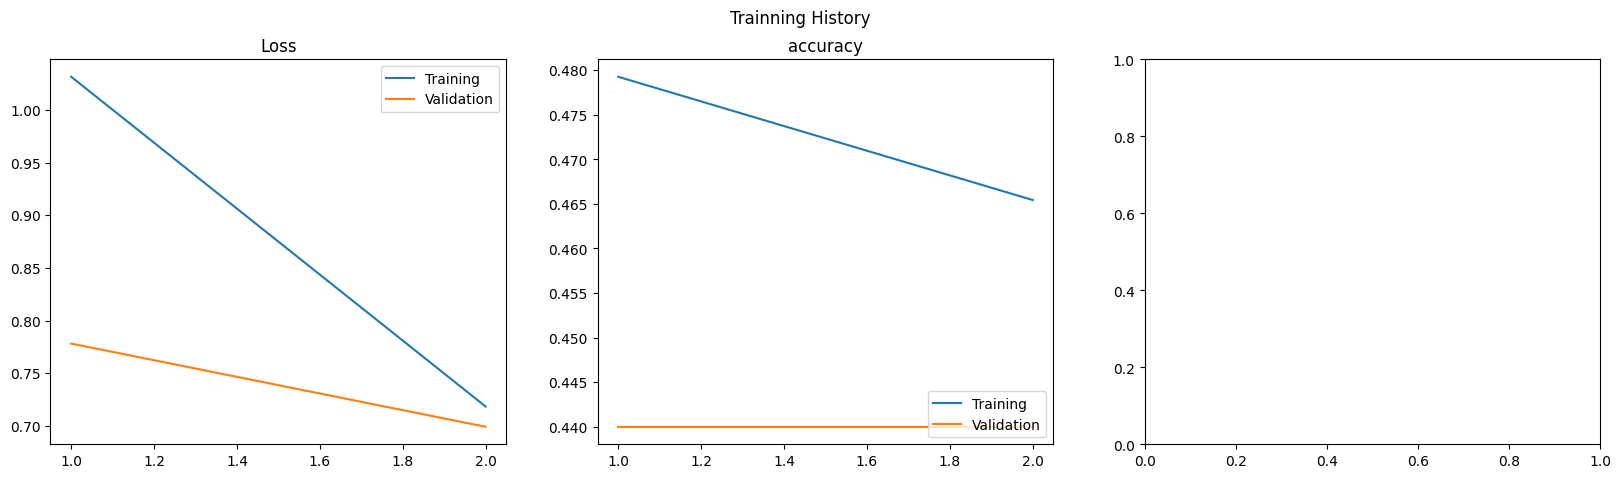

In [ ]:
Utils.plot_model_history(history, "Trainning History")

-------------------------------------------------------------------------------------


- record trainning data (loss + accuracy / per epoch) + time per row ?
- mathplot lib graphs of trainnings
- record final result